In [3]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(font_scale=2, style='ticks')
from activity_swim_bout import *
from utils import cont_mode
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from utils import *
from scipy.signal import find_peaks

In [4]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

vol_file = Path('depreciated/analysis_opto_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [75]:
def lda_trace(row):
    #row = dat_xls_file.iloc[5]
    folder = row['folder']
    fish = row['fish']
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = frame_stimParams[2,swim_starts] # 1, low; 2 high
    task_period = task_period + frame_stimParams[3,swim_starts]*2 -2 # 
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    for n_ in range(len(swim_starts)):
        if (swim_starts[n_]>opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<10*300:
            task_period[n_] = task_period[n_] + 2
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<300:
            task_period[n_] = np.nan
        if (swim_starts[n_]<opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]<opto_t][0]>-300:
            task_period[n_] = np.nan

    count_, _ = np.histogram(task_period, bins=range(8))
    if count_[1]<100:
        return None

    win_size = 3
    first_swim_bout_index = [np.where((task_period[:-1]!=5) & (task_period[1:]==5))[0]+1]
    first_swim_bout_index.append(np.where((task_period[:-1]!=6) & (task_period[1:]==6))[0]+1)

    if win_size > 1:
        first_swim_bout_index[0] = np.concatenate([first_swim_bout_index[0]+_ for _ in range(win_size)])
        first_swim_bout_index[0] = first_swim_bout_index[0][first_swim_bout_index[0]<len(task_period)]
        first_swim_bout_index[1] = np.concatenate([first_swim_bout_index[1]+_ for _ in range(win_size)])
        first_swim_bout_index[1] = first_swim_bout_index[1][first_swim_bout_index[1]<len(task_period)]

    for clip_index in first_swim_bout_index:
        task_period[clip_index] = np.nan

    # remove low firing neurons
    low_fire = spk.mean(axis=-1)*300 < 0.1
    spk = spk[~low_fire, :]

    if spk.shape[0]<5:
        return None

    spk_list = np.zeros((r_swim.shape[0], spk.shape[0]))
    remove_list = np.zeros(r_swim.shape[0]).astype('bool')

    for n, n_swim in enumerate(swim_starts):
        try:
            spk_list[n, :] = spk[:, n_swim+0:n_swim+300].mean(axis=-1)*300
        except:
            remove_list[n]=True
    task_period_ = task_period.copy()
    task_period_[remove_list] = 0
    spk_list_ = np.array(spk_list)
    lda = LDA()
    lda.fit(spk_list_[task_period_<3, :], task_period_[task_period_<3])
    lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3])
    coef_ = lda.coef_

    if lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3])<0.7:
        return None

    print(f'Processing {folder} {fish}')
    print(lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3]))

    k_ = boxcarKernel(900)
    spk_smooth = spk.copy()
    for ncell in range(spk_smooth.shape[0]):
        spk_smooth[ncell] = smooth(spk[ncell], k_)*300
    pop_act = spk_smooth.T.dot(coef_.T)
    pop_act = pop_act.ravel()

    opto_epoch = frame_stimParams[3]
    trial_ = frame_stimParams[4]
    if spk.shape[-1]>len(trial_):
        trial_ = np.concatenate([trial_, np.zeros(spk.shape[-1]-len(trial_))])
    else:
        trial_ = trial_[:spk.shape[-1]]
    num_trial = trial_.max().astype('int')-1

    spk_list = []
    for ntrial in range(num_trial):
        spk_list.append(pop_act[trial_==ntrial+1])
    trial_len = min([_.shape for _ in spk_list])[0]
    spk_list_ = np.vstack([_[:trial_len] for _ in spk_list])
    k_ = boxcarKernel(sigma=50)
    ave_ = np.mean(spk_list_, axis=0)
    sem_ = np.std(spk_list_, axis=0)/np.sqrt(num_trial)
    epoch_len = trial_len//4
    labels = ['low', 'high', 'low+optv', 'high+optv']

    cstyle = ['-k', '-r', '--k', '--r']
    for n_epoch in range(4):
        ave__ = ave_[n_epoch*epoch_len:(n_epoch+1)*epoch_len]
        sem__ = sem_[n_epoch*epoch_len:(n_epoch+1)*epoch_len]
        plt.plot(np.arange(epoch_len)/300, ave__, cstyle[n_epoch], lw=2.0, label=labels[n_epoch])
#         plt.plot(np.arange(epoch_len)/300, ave__+sem__, cstyle[n_epoch], lw=0.5)
#         plt.plot(np.arange(epoch_len)/300, ave__-sem__, cstyle[n_epoch], lw=0.5)
    plt.vlines([10], [0], [2], linestyles='--', color='k')
    plt.xlim([0, epoch_len/300])
#     plt.ylim([-1, 2])
    sns.despine()
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
    plt.xlabel('Time from epoch onset')
    plt.ylabel('Neural act., coding direction')    
    plt.show()

Processing 01312019 Fish3-3
0.7202572347266881


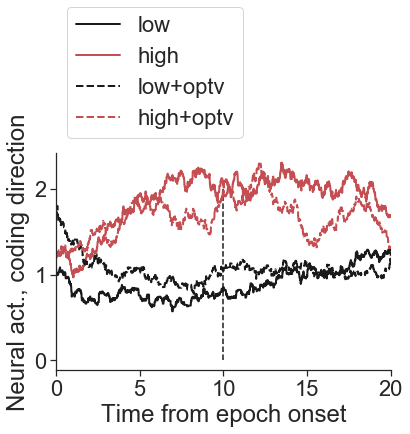

Processing 02142019 Fish2-6
0.7063197026022305


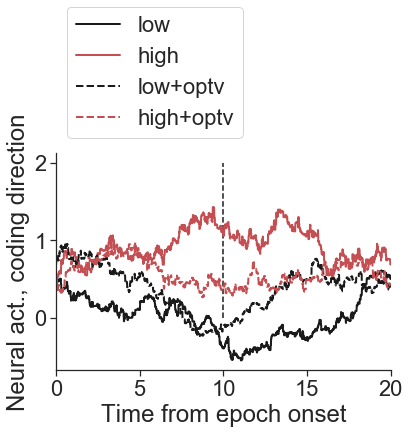

In [76]:
for _, row in dat_xls_file.iterrows():
    lda_trace(row)

## check if the fish has a memory

In [ ]:
from scipy.signal import find_peaks
num_burst = np.zeros(r_swim.shape[0])
int_burst = np.zeros(r_swim.shape[0])
max_burst = np.zeros(r_swim.shape[0])
ave_burst = np.zeros(r_swim.shape[0])
fir_burst = np.zeros(r_swim.shape[0])

for n_burst in range(r_swim.shape[0]):
    rswim = r_swim[n_burst, 50:200]
    lswim = l_swim[n_burst, 50:200]
    swim_ = np.sqrt(rswim**2+lswim**2)
    peaks_ = find_peaks(swim_, prominence=0.5)[0] 
#     peaks_rl = rswim[peaks]>lswim[peaks]
#     peaks_r = peaks[peaks_rl]
#     peaks_l = peaks[~peaks_rl]
#     if rswim.max()>lswim.max():
#         peaks_ = peaks_r
#         swim_ = rswim
#     else:
#         peaks_ = peaks_l
#         swim_ = lswim   
    if len(peaks_) >1:
        num_burst[n_burst] = len(peaks_)/2
        int_burst[n_burst] = np.nanmean(np.diff(peaks_))
        max_burst[n_burst] = swim_.max()
        ave_burst[n_burst] = swim_[peaks_].mean()
        fir_burst[n_burst] = peaks_[0]
    
burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
burst_list = np.asarray(burst_list)